## Import

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import Sequential, Input
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.losses import CategoricalCrossentropy
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.regularizers import l2, l1
from tensorflow.python.keras.metrics import Accuracy, SparseCategoricalAccuracy, CategoricalAccuracy, AUC, \
    PrecisionAtRecall
from tensorflow.python import keras

### Load data

In [2]:

import pandas as pd
df_preprocess = pd.read_csv('../data/predictive_maintenance_preprocess.csv', index_col=0)

Extract the name of variable of 'Target'

In [3]:
name_target_col = list(filter(lambda ligne: 'Target' in ligne, df_preprocess.columns))

Separation of explanatory variables and variables to identify

In [4]:
x = df_preprocess.drop(columns=name_target_col)
y = df_preprocess[name_target_col]

### UP sampling data

In [6]:

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=12)
X_resampled, y_resampled = smote.fit_resample(x.to_numpy(), y.to_numpy())

In [8]:

import numpy as np
unique_values, counts = np.unique(y_resampled, return_counts=True)

In [9]:

X_resampled = pd.DataFrame(X_resampled, columns=x.columns)
y_resampled = pd.DataFrame(pd.get_dummies(y_resampled))
y_resampled.columns=['Target_0', 'Target_1','Target_2', 'Target_3','Target_4']

Check if there is Nan Value

In [10]:
print(np.isnan(y_resampled).any())

Target_0    False
Target_1    False
Target_2    False
Target_3    False
Target_4    False
dtype: bool


### Create train and test data

In [12]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

In [13]:
num_features = X_resampled.shape[1] # Nombre de variables explicatives
num_target = y_resampled.shape[1]   # Nombre de variables cibles

In [29]:

keras.backend.clear_session()




### Create model

In [34]:

model = Sequential()
model.add(Input(shape=(num_features,)))

model.add(Dense(units=1024, activation='relu', kernel_regularizer=l1()))
model.add(Dense(units=512, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(units=num_target, activation='softmax'))


model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(5e-4), 
              metrics=[PrecisionAtRecall(recall=0.8), CategoricalAccuracy(), AUC()])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1024)              11264     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

In [36]:

ModelCheckpoint = ModelCheckpoint(
    filepath='../Model/best_model.h5',
    save_best_only=True,
    monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)

In [37]:
EPOCH=80
BATCH_SIZE =128

### Training

In [38]:
history=model.fit(x=X_train.to_numpy(),
                  y=y_train.to_numpy(),
                  validation_data=(X_test.to_numpy(),y_test.to_numpy()),
                  epochs=EPOCH, 
                  batch_size=BATCH_SIZE,
                  callbacks=[ModelCheckpoint, early_stopping, reduce_lr])

Epoch 1/80
302/302 [==============================] - 4s 10ms/step - loss: 1.2320 - precision_at_recall_1: 0.9503 - categorical_accuracy: 0.8924 - auc_1: 0.9851 - val_loss: 0.4508 - val_precision_at_recall_1: 0.9705 - val_categorical_accuracy: 0.9189 - val_auc_1: 0.9913
Epoch 2/80
302/302 [==============================] - 4s 13ms/step - loss: 0.2892 - precision_at_recall_1: 0.9848 - categorical_accuracy: 0.9577 - auc_1: 0.9954 - val_loss: 0.2758 - val_precision_at_recall_1: 0.9878 - val_categorical_accuracy: 0.9495 - val_auc_1: 0.9953
Epoch 3/80
302/302 [==============================] - 5s 16ms/step - loss: 0.2271 - precision_at_recall_1: 0.9888 - categorical_accuracy: 0.9649 - auc_1: 0.9965 - val_loss: 0.1747 - val_precision_at_recall_1: 0.9934 - val_categorical_accuracy: 0.9770 - val_auc_1: 0.9985
Epoch 4/80
302/302 [==============================] - 4s 15ms/step - loss: 0.1978 - precision_at_recall_1: 0.9897 - categorical_accuracy: 0.9693 - auc_1: 0.9970 - val_loss: 0.1484 - val_p

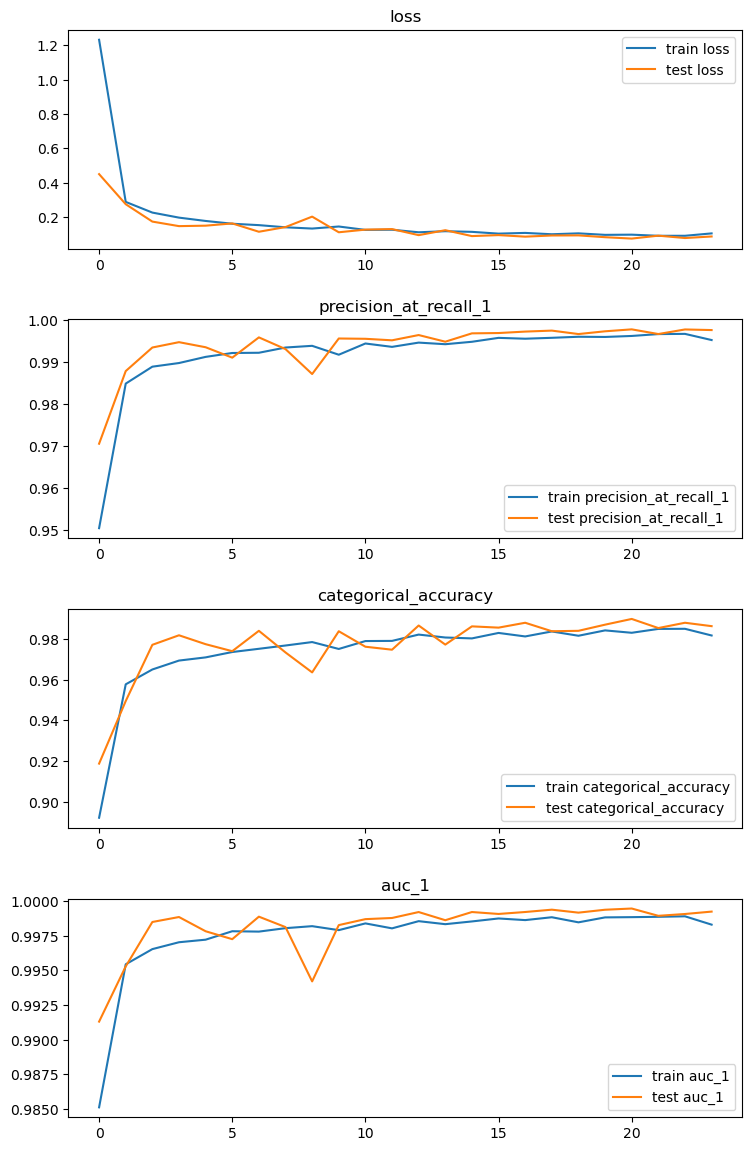

In [45]:
def plot_history(history):
    list_metrics = []
    
    for st in history.keys():
        if not st.startswith('val') and not st.__contains__('lr'):
            list_metrics.append(st)

    fig, axs = plt.subplots(len(list_metrics), figsize=(8,12))
    fig.tight_layout(pad=3.0)
    
    for i, metrics in enumerate(list_metrics):
        length = len(history[metrics])
        axs[i].plot(np.arange(length), history[metrics], label='train '+metrics)
        axs[i].plot(np.arange(length), history['val_'+metrics], label='test '+metrics)
        axs[i].set_title(metrics)
        axs[i].legend()
        
    plt.show()

plot_history(history.history)